In [12]:
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
from Bio import Phylo
import subprocess
import gzip
import pandas as pd

In [13]:
BUFFER = 20 # with the block indexing
samtools = "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/DWGSIM/samtools/samtools"

In [14]:
coverage = 20
resolution = 960

# seq_dict = {
#     "resolution": 960,
#     "block_length": 60
# }

read_dict = {
    "readlen": 150,
    "outerdist": 1500, 
    "numreads": 50000,
    "readmode": 1
}

exp_dict = {
    "p": "exp46"
}

# FIXME later, want these to be high level and then we do
# one more level for mixtures
OUTDIR = "/Users/rfeld/Documents/Research/SPATIAL/output"
outdir = f'{OUTDIR}/experiments/{exp_dict["p"]}'
_seqdir = f'{outdir}/sequences'
_readdir = f'{outdir}/reads'

subprocess.call(["mkdir", "-p", _seqdir])
subprocess.call(["mkdir", "-p", _readdir])

log = f'{outdir}/log.txt'

In [15]:
# Parse reference FASTA
refname = "/Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa"
ref = []
with open(refname, 'r') as f:
    for line in f:
        if not line.startswith(">"):
            ref.append(line.strip())

# Each line ~60bp → group 16 lines into 960bp block
ref_blocks = []
for i in range(0, len(ref), 16):
    block = "".join(ref[i:i+16])
    ref_blocks.append(block)

# Optional: track index
ref_idx = list(range(len(ref_blocks)))
reflength = 960 * (len(ref_blocks) - 1) + len(ref_blocks[-1])

In [16]:
# TREE CONSTRUCTION
resolution = 960
cn_length_mean = 1000000
geom_p = 0.5
diploid_blocks = ref_idx.copy()
nwk_string = "(cell1:0.1)founder;"
n_manual_mutations = 1 

def mutate(b_rel_idx, b_rel_start, b_length, copies):
    region = copies * b_rel_idx[b_rel_start:b_rel_start + b_length]
    return b_rel_idx[:b_rel_start] + region + b_rel_idx[b_rel_start + b_length:]

def generate_random_mutation(b_rel_idx):
    num_regions = len(b_rel_idx)
    CN_size = max(min(round(np.random.exponential(cn_length_mean / resolution)), num_regions), 1)
    CN_type = np.random.binomial(1, 0.5)
    CN_copies = np.random.geometric(0.5) + 1 if CN_type == 1 else 0
    b_start_idx = np.random.randint(num_regions - CN_size + 1)
    return {
        "copies": CN_copies,
        "start_idx": b_start_idx,
        "length_blocks": CN_size,
        "region_length": CN_size * resolution,
        "total_length": CN_copies * CN_size * resolution,
        "prev_start_idx": b_start_idx * resolution + 1,
        "prev_end_idx": (b_start_idx + CN_size) * resolution
    }

def apply_mutation_and_trace(blocks, mutation):
    #FIXME not tracing
    return mutate(blocks, mutation["start_idx"], mutation["length_blocks"], mutation["copies"])

def simulate_cell_mutations(blocks, n_mut):
    mutations = []
    for _ in range(n_mut):
        md = generate_random_mutation(blocks)
        blocks = apply_mutation_and_trace(blocks, md)
        mutations.append(md)
    return blocks, mutations

def simulate_diploid_cell(parent_blocks, n0, n1, inherited_mutations, logf, name):
    all_mutations = {}
    final_blocks = {}
    for allele, n_mut in [(0, n0), (1, n1)]:
        blocks = parent_blocks[allele]
        inherited = inherited_mutations[allele].copy()
        logf.write(f"\n{name} allele {allele}: Starting with {len(blocks)} blocks\n")
        for md in inherited:
            blocks = apply_mutation_and_trace(blocks, md)
        blocks, new_muts = simulate_cell_mutations(blocks, n_mut)
        all_mutations[allele] = inherited + new_muts
        final_blocks[allele] = blocks
        logf.write(f"{name} allele {allele}: {n_mut} new mutations, final length: {len(blocks)}\n")
        for i, md in enumerate(new_muts):
            logf.write(f"  Mutation {i+1}: start_idx={md['start_idx']}, "
                       f"length_blocks={md['length_blocks']}, "
                       f"copies={md['copies']}\n")
    return all_mutations, final_blocks

def construct(nwk_string):
    tree = Phylo.read(StringIO(nwk_string), "newick")
    tree.ladderize()
    parent_map = {child: clade for clade in tree.find_clades(order="level") for child in clade.clades}
    cumulative_genomes = {}
    mutation_records = {}

    with open(log, "w") as logf:
        for node in tree.find_clades(order="level"):
            if not node.name:
                continue
            logf.write(f"\nProcessing {node.name}...\n")
            parent = parent_map.get(node)
            if parent is None:
                cumulative_genomes[node.name] = {0: diploid_blocks.copy(), 1: diploid_blocks.copy()}
                mutation_records[node.name] = {0: [], 1: []}
                continue
            inherited_mutations = mutation_records[parent.name]
            parent_blocks = {}
            for allele in [0, 1]:
                blocks = diploid_blocks.copy()
                for md in inherited_mutations[allele]:
                    blocks = apply_mutation_and_trace(blocks, md)
                parent_blocks[allele] = blocks
            muts, final_blocks = simulate_diploid_cell(
                parent_blocks, n_manual_mutations, 0,
                inherited_mutations, logf, node.name
            )
            mutation_records[node.name] = muts
            cumulative_genomes[node.name] = final_blocks
    
    return tree, mutation_records, cumulative_genomes

In [17]:
tree, mutation_records, cumulative_genomes = construct(nwk_string)
mut = mutation_records["cell1"][0][0]
left = mut["start_idx"]
right = mut["length_blocks"] * mut["copies"] + left

In [18]:
# FASTA WRITING AND CHECK
def write_fasta(block_index, header, ref, fname, fpath):
    seq = [ref[i] for i in block_index]
    fasta_loc = f"{fpath}/{fname}.fa"
    with open(fasta_loc, "w") as f:
        f.write(f">{header}\n")
        for block in seq:
            for i in range(0, len(block), 60):
                f.write(block[i:i+60] + "\n")
    
    return fasta_loc

def write_fasta_slice(block_index, ref, left, right, buffer, 
                      header, name, fpath):
    # ASSUME BLOCK INDICES FOR left, right
    l = max(0, left - buffer)
    r = min(right + buffer, len(block_index))

    left = l * resolution + 1
    right = r * resolution

    fasta_loc = f"{fpath}/{name}_{left}_{right}.fa"

    seq = [ref[i] for i in block_index][l:r]
    with open(fasta_loc, "w") as f:
        f.write(f">{header}\n")
        for block in seq:
            for i in range(0, len(block), 60):
                f.write(block[i:i+60] + "\n")
    
    return fasta_loc

fasta_name = "cell1_0"
cell1_0_seq = cumulative_genomes["cell1"][0]

full_fasta_loc = write_fasta(cell1_0_seq, fasta_name, ref_blocks, fasta_name, _seqdir)

slice_fasta_loc = write_fasta_slice(cell1_0_seq, ref_blocks, left, right, BUFFER, 
                      fasta_name, fasta_name, _seqdir)

# index fastas 
subprocess.call(f"{samtools} faidx {full_fasta_loc}", shell = True, cwd=_seqdir)
subprocess.call(f"{samtools} faidx {slice_fasta_loc}", shell = True, cwd=_seqdir)

0

In [19]:
# FIXME crimes against humanity
_data = slice_fasta_loc.split("/")[-1].split(".")[0].split("_")[2:]
left, right = int(_data[0]), int(_data[1])

In [ ]:
def _filter_reads(input_file, output_file, names_to_keep):
    with gzip.open(input_file, 'rt') as f_in, open(output_file, 'w') as f_out:
        while True:
            header = f_in.readline()
            seq = f_in.readline()
            plus = f_in.readline()
            qual = f_in.readline()
            if not header:
                break
            read_name = header.strip().split()[0].replace("/1", "").replace("/2", "")
            if read_name in names_to_keep:
                f_out.write(header + seq + plus + qual)

def _get_read_names(file_path, name):
    read_names = set()
    with gzip.open(file_path, 'rt') as f:
        while True:
            header = f.readline().strip()
            f.readline()  # seq
            f.readline()  # plus
            f.readline()  # qual
            if not header:
                break
            if header.startswith(f"@{name}"):  # Mapped reads
                read_name = header.split()[0].replace("/1", "").replace("/2", "")
                read_names.add(read_name)
    return read_names

def _compute_lr(mode):
    if mode == 0:
        pass
    elif mode == 1:
        def compute_lr(row):
            if row["strand"] == 1:
                l = row["pos"]; r = row["mpos"]
            else:
                l = row["mpos"]; r = row["pos"]
            return pd.Series({"l": l, 
                              "r": r})
    elif mode == 2:
        pass

    return compute_lr

def readstep(d, readdir, refloc, header, mut_id, read_prefix, aug_fp, verbose = False, log = ""):
    cprint = lambda x: print(x) if verbose else ""

    read1 = f"{readdir}/{read_prefix}.bwa.read1.fastq"
    read2 = f"{readdir}/{read_prefix}.bwa.read2.fastq"

    line =f"dwgsim -N {d['numreads']} -1 {d['readlen']} -2 {d['readlen']} -d {d['outerdist']} -S {d['readmode']} {aug_fp} {read_prefix}"
    subprocess.call(line, shell = True, cwd=readdir)

    compute_lr = _compute_lr(d['readmode'])

    # Define input and output files
    cwd = readdir
    read1 = f"{readdir}/{read_prefix}.bwa.read1.fastq.gz"
    read2 = f"{readdir}/{read_prefix}.bwa.read2.fastq.gz"
    dual_read1 = f"{readdir}/filtered_read1.fastq"
    dual_read2 = f"{readdir}/filtered_read2.fastq"
    unmapped = f"{readdir}/unmapped.fastq"

    # 1. Extract read names from both files
    cprint("Extracting read names...")
    read1_names = _get_read_names(read1, header)
    read2_names = _get_read_names(read2, header)

    # 2. Identify dually mapped and unmapped reads
    dually_mapped = read1_names & read2_names
    unmapped_reads = (read1_names | read2_names) - dually_mapped

    cprint(f"Found {len(dually_mapped)} dually mapped reads.")
    cprint(f"Found {len(unmapped_reads)} unmapped reads.")

    # 4. Filter dually mapped reads
    cprint("Filtering dually mapped reads...")
    _filter_reads(read1, dual_read1, dually_mapped)
    _filter_reads(read2, dual_read2, dually_mapped)

    # 5. Filter unmapped reads (combine both ends)
    cprint("Filtering unmapped reads...")
    with open(unmapped, 'w') as f_out:
        _filter_reads(read1, f_out.name, unmapped_reads)
        _filter_reads(read2, f_out.name, unmapped_reads)
    
    readprocessing2 = [
        f"bwa mem {refloc} {dual_read1} {dual_read2} > {readdir}/target_{mut_id}.sam",
        f"{samtools} view -bT {refloc} {readdir}/target_{mut_id}.sam > {readdir}/target_{mut_id}.bam",
        f"{samtools} sort {readdir}/target_{mut_id}.bam > {readdir}/target_{mut_id}_sorted.bam",
        f'{samtools} view -F 4 -f 8 {readdir}/target_{mut_id}.bam |' + " awk '{print $1, $2, $4, $8, $5}' > lmapped.txt",
        f'{samtools} view -F 8 -f 4 {readdir}/target_{mut_id}.bam |'  " awk '{print $1, $2, $4, $8, $5}' > rmapped.txt",
        f'{samtools} view -f 0x2 {readdir}/target_{mut_id}.bam |' + " awk '{print $1, $2, $4, $8, $5}' > fullmapped.txt"]


    for line in readprocessing2:
        subprocess.call(line, shell = True, cwd=readdir)

    
    threshold = d["signal_threshold"] 
    compute_lr = _compute_lr(1)
    data = f"{readdir}/fullmapped.txt"

    rows = []
    with open(data, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            read_name = parts[0]
            flag = int(parts[1])
            pos = int(parts[2])
            mpos = int(parts[3])
            mapq = int(parts[4])
            rows.append((read_name, flag, pos, mpos, mapq))

    bnames = ["paired", "proper", "unmapped_q", "mate_unmapped", "strand", "mate_strand",
            "first_read", "second_read", "not_prim", "QC", "op_PCR"][::-1]
    flags_bin  = [bin(flag)[2:].zfill(12)[-11:] for _, flag, _, _, _ in rows]

    decoded = [{name: int(bit) for name, bit in zip(bnames, bits)}  for bits in flags_bin]

    filtered_rows = [
        (*row, decoded[i])
        for i, row in enumerate(rows)
        if decoded[i]["proper"] == 1 and decoded[i]["first_read"] == 1]
    
    # ----- Compute l, r -----
    results = []
    for row in filtered_rows:
        read_name, flag, pos, mpos, mapq, flag_dict = row
        l_r = compute_lr({
            "pos": pos,
            "mpos": mpos,
            "strand": flag_dict["strand"]
        })
        l = l_r["l"]
        r = l_r["r"]
        results.append((read_name, l, r, mapq)) 

    # ----- Apply suspect filter -----
    suspects = [
        (read_name, l, r, mapq)
        for read_name, l, r, mapq in results
        if (l > r or (r - l > threshold))
    ]

    if log != "":
        with open(log, "a+") as f:
            f.write(f"Generated {len(filtered_rows)} mapped reads, found {len(suspects)} jump events.")

    return results, suspects

# results, suspects = readstep(read_dict, _readdir, refname, fasta_name, 0, 0, slice_fasta_loc, verbose = False, log = "")

In [ ]:
lengths = [r - l for _, l, r, _ in results if r > l]
# Filter out extreme values for better visualization
filtered_lengths = [x for x in lengths if x < 5000]  # Adjust cutoff as needed

plt.figure(figsize=(6, 5))
plt.hist(filtered_lengths, bins=100)
plt.title("Insert Size Distribution")
plt.xlabel("Insert size (bp)")
plt.ylabel("Count")
plt.show()

In [ ]:
def visualize_coverage(
    results,
    genome_length=None,
    bins=1000,
    left=None,
    right=None,
    title="Read Coverage",
    figsize=(12, 4),
    mark_region_start=None,
    mark_region_end=None,
):
    """
    Visualize read coverage along a genome or a specific region.
    Optionally mark a central region (e.g., a mutation site).

    Parameters:
    - results: list of tuples (read_name, l, r, mapq)
    - genome_length: total length of the reference genome
    - bins: number of bins to aggregate coverage into
    - left, right: region of the genome to visualize
    - mark_region_start, mark_region_end: coordinates to mark with vertical lines
    """
    if not results:
        print("No reads to plot.")
        return

    max_coord = max(max(l, r) for _, l, r, _ in results)
    genome_length = genome_length or max_coord

    left = max(0, left or 0)
    right = min(genome_length, right or genome_length)

    coverage = np.zeros(genome_length + 1, dtype=int)

    for _, l, r, _ in results:
        read_start = min(l, r)
        read_end = max(l, r)
        if read_end <= left or read_start >= right:
            continue
        start = max(read_start, left)
        end = min(read_end, right)
        coverage[start:end] += 1

    coverage_window = coverage[left:right]
    window_len = right - left

    if window_len > bins:
        bin_edges = np.linspace(0, window_len, bins + 1, dtype=int)
        binned_cov = np.add.reduceat(coverage_window, bin_edges[:-1])
        x = np.linspace(left, right, bins)
        y = binned_cov
    else:
        x = np.arange(left, right)
        y = coverage_window

    plt.figure(figsize=figsize)
    plt.plot(x, y, lw=1)
    plt.xlabel("Genome position")
    plt.ylabel("Coverage (Read Depth)")
    plt.title(title)

    # Add vertical markers
    if mark_region_start is not None:
        plt.axvline(mark_region_start, color='red', linestyle='--', label="Region Start")
    if mark_region_end is not None:
        plt.axvline(mark_region_end, color='orange', linestyle='--', label="Region End")

    if mark_region_start is not None or mark_region_end is not None:
        plt.legend()

    plt.tight_layout()
    plt.show()

left = mut["prev_start_idx"] - (resolution * (BUFFER + 5))
right = mut["prev_end_idx"] + (resolution * (BUFFER + 5))
visualize_coverage(
    results,
    genome_length=reflength,
    left=left,
    right=right,
    mark_region_start=mut["prev_start_idx"],
    mark_region_end=mut["prev_end_idx"]
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_islands_from_results(
    results,
    threshold=10000,
    region_start=None,
    region_end=None,
    cmap="viridis",
    figsize=(8, 6),
    show_all_reads=True,
    alpha_all=0.2,
    alpha_island=0.8,
    label_fontsize=10,
    mark_true_islands=True,
):
    """
    Plot (l, r) pairs from results, highlighting islands and true positives.

    Parameters:
    - results: list of (read_name, l, r, mapq)
    - threshold: span threshold to call an island
    - region_start, region_end: true insertion region boundaries
    - cmap: colormap for MAPQ
    - figsize: plot size
    - show_all_reads: show non-island high-quality reads in gray
    - alpha_all: transparency for background reads
    - alpha_island: transparency for island reads
    - label_fontsize: font size
    - mark_true_islands: show stars for true positive islands
    """
    if not results:
        print("No reads to plot.")
        return

    arr = np.array(results, dtype=object)
    l_coords = arr[:, 1].astype(int)
    r_coords = arr[:, 2].astype(int)
    mapqs = arr[:, 3].astype(int)

    island_mask = (l_coords > r_coords) | ((r_coords - l_coords) > threshold)
    highq_mask = mapqs == 60
    non_island_mask = ~island_mask
    background_mask = highq_mask & non_island_mask

    # True islands: coordinate flip + both endpoints inside mutation region
    if region_start is not None and region_end is not None:
        true_ins_mask = (l_coords > r_coords) & (r_coords > region_start) & (l_coords < region_end)
        true_del_mask = (l_coords < r_coords) & (l_coords < region_start) & (r_coords > region_end)
        true_island_mask = true_ins_mask | true_del_mask
    else:
        true_island_mask = np.zeros_like(l_coords, dtype=bool)

    plt.figure(figsize=figsize)

    if show_all_reads:
        plt.scatter(
            l_coords[background_mask],
            r_coords[background_mask],
            color="gray",
            alpha=alpha_all,
            s=10,
            label="MAPQ 60 Non-Island"
        )

    # Main island scatter
    sc = plt.scatter(
        l_coords[island_mask],
        r_coords[island_mask],
        c=mapqs[island_mask],
        cmap=cmap,
        alpha=alpha_island,
        s=20,
        label="Islands"
    )

    # Overlay true islands as stars
    if mark_true_islands and np.any(true_island_mask):
        plt.scatter(
            l_coords[true_island_mask],
            r_coords[true_island_mask],
            color="gold",
            marker="*",
            s=80,
            edgecolor="black",
            label="True Positive Islands"
        )

    # Mutation region overlays
    if region_start is not None:
        plt.axvline(region_start, color="red", linestyle="--", label="Mutation Start")
        plt.axhline(region_start, color="red", linestyle="--")
    if region_end is not None:
        plt.axvline(region_end, color="orange", linestyle="--", label="Mutation End")
        plt.axhline(region_end, color="orange", linestyle="--")

    plt.colorbar(sc, label="MAPQ")
    plt.xlabel("l (left endpoint)", fontsize=label_fontsize)
    plt.ylabel("r (right endpoint)", fontsize=label_fontsize)
    plt.title("Detected and True Islands", fontsize=label_fontsize + 2)
    plt.grid(True)
    plt.legend(fontsize=label_fontsize)
    plt.tight_layout()
    plt.show()

plot_islands_from_results(
    results,
    threshold=10000,
    region_start=mut["prev_start_idx"],
    region_end=mut["prev_end_idx"],
    show_all_reads=False,
    mark_true_islands=True)

In [ ]:
# experimental loop 
# had 250 in there originally - too small to control flip. 
outer_dist = [500, 750, 1000, 1250, 1500, 1750, 2000]
coverage = 15

# greedy checking
max_mut_size = 1_000_000
min_mut_size = 200_000

data = dict()

for od in outer_dist:
    od_data = dict()
    od_data["true_signals"] = []
    od_data["signals"] = []
    od_data["results"] = []
    od_data["mut"] = []
    # GENERATION
    for i in range(50):
        print(f"od = {od}, i = {i}")
        this_len = 10_000_000
        while this_len > max_mut_size:
            tree, mutation_records, cumulative_genomes = construct(nwk_string) 
            mut = mutation_records["cell1"][0][0] 
            left = mut["start_idx"] 
            right = mut["length_blocks"] * mut["copies"] + left 
            this_len = (right - left) * resolution

        fasta_name = "cell1_0"
        cell1_0_seq = cumulative_genomes["cell1"][0]
        full_fasta_loc = write_fasta(cell1_0_seq, fasta_name, ref_blocks, fasta_name, _seqdir)
        slice_fasta_loc = write_fasta_slice(cell1_0_seq, ref_blocks, left, right, BUFFER,
                                            fasta_name, fasta_name, _seqdir) 
        subprocess.call(f"{samtools} faidx {slice_fasta_loc}", shell = True, cwd=_seqdir)
        subprocess.call(f"{samtools} faidx {full_fasta_loc}", shell = True, cwd=_seqdir)

        _data = slice_fasta_loc.split("/")[-1].split(".")[0].split("_")[2:]
        left, right = int(_data[0]), int(_data[1]) # actual written region

        numreads = coverage * (right - left) // (2 * read_dict["readlen"]) 

        read_dict["numreads"] = numreads 

        results, suspects = readstep(read_dict, _readdir, refname, 
                                    fasta_name, 0, 0, slice_fasta_loc, 
                                    verbose = False, log = "")

        arr = np.array(results, dtype=object)

        if len(arr) != 0:
            l_coords = arr[:, 1].astype(int)
            r_coords = arr[:, 2].astype(int)
            mapqs = arr[:, 3].astype(int)

            threshold = od * 5 + 2 * read_dict['readlen']
            island_mask = (l_coords > r_coords) | ((r_coords - l_coords) > threshold)
            highq_mask = mapqs == 60
            non_island_mask = ~island_mask
            background_mask = highq_mask & non_island_mask

            region_start = mut["prev_start_idx"]
            region_end = mut["prev_end_idx"]

            true_ins_mask = (l_coords > r_coords) & (r_coords > region_start) & (l_coords < region_end)
            true_del_mask = (l_coords < r_coords) & (l_coords < region_start) & (r_coords > region_end)
            true_island_mask = true_ins_mask | true_del_mask 

            od_data["true_signals"].append(true_island_mask.sum())
            od_data["signals"].append(island_mask.sum()) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        else:
            od_data["true_signals"].append(0)
            od_data["signals"].append(0) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        
    od_data["true_signals"] = np.asarray(od_data['true_signals'])
    od_data["true_rate"] = od_data["true_signals"].mean() 
    od_data["signals"] = np.asarray(od_data["signals"])
    od_data["signal_rate"] = od_data["signals"].mean()
    data[od] = od_data

In [ ]:
true_signal_array = [data[od]["true_signals"] for od in outer_dist]

In [ ]:
true_signal_array

In [ ]:
signals = [data[od]["signal_rate"] for od in outer_dist]
true_signals = [data[od]["true_rate"] for od in outer_dist]

In [ ]:
signals

In [ ]:
plt.plot(outer_dist, signals, label = "signals")
plt.plot(outer_dist, true_signals, label = "true signals") 
plt.legend()
plt.title("Outer Distance vs. Signal Rate")

In [ ]:
triples = [[(d["mut"][i]['region_length'], d["signals"][i], d["true_signals"][i]) for i in range(10)] for d in data.values()]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

cmap   = cm.get_cmap("tab10")                      # 10 easily-distinct colours
fig, ax = plt.subplots(figsize=(7, 4))

for idx, sub in enumerate(triples):
    clr = cmap(idx % cmap.N)                       # pick a colour for this list

    # unpack once so we don't call t[0] etc. repeatedly
    xs  = [int(t[0]) for t in sub]
    y2s = [int(t[1]) for t in sub]
    y3s = [int(t[2]) for t in sub]

    # 1️⃣  scatter the two sets of points
    ax.scatter(xs, y2s, color=clr, marker="o", s=40, label=f"group {idx} (y₂)")
    ax.scatter(xs, y3s, color=clr, marker="^", s=40, label=f"group {idx} (y₃)")

    # 2️⃣  draw connecting lines
    for x, y2, y3 in zip(xs, y2s, y3s):
        ax.plot([x, x], [y2, y3], color=clr, linewidth=1)

# tidy up
ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("y₂ and y₃ for each tuple; lines connect each pair")
ax.legend(ncol=2, fontsize=8)
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
for i in range(len(outer_dist)):
    od = outer_dist[i]
    arr = np.asarray(triples[i])

    plt.scatter(arr[:, 0], arr[:, 2], label = f"{od}")
plt.legend()

In [ ]:
# experimental loop 
# had 250 in there originally - too small to control flip. 
outer_dist = [500, 750, 1000, 1250, 1500, 1750, 2000]
coverage = 10

# greedy checking
max_mut_size = 1_000_000
min_mut_size = 200_000

data2 = dict()

for od in outer_dist:
    od_data = dict()
    od_data["true_signals"] = []
    od_data["signals"] = []
    od_data["results"] = []
    od_data["mut"] = []
    # GENERATION
    for i in range(10):
        print(f"od = {od}, i = {i}")
        this_len = 10_000_000
        while this_len > max_mut_size or this_len < min_mut_size:
            tree, mutation_records, cumulative_genomes = construct(nwk_string) 
            mut = mutation_records["cell1"][0][0] 
            left = mut["start_idx"] 
            right = mut["length_blocks"] * mut["copies"] + left 
            this_len = (right - left) * resolution

        fasta_name = "cell1_0"
        cell1_0_seq = cumulative_genomes["cell1"][0]
        full_fasta_loc = write_fasta(cell1_0_seq, fasta_name, ref_blocks, fasta_name, _seqdir)
        slice_fasta_loc = write_fasta_slice(cell1_0_seq, ref_blocks, left, right, BUFFER,
                                            fasta_name, fasta_name, _seqdir) 
        subprocess.call(f"{samtools} faidx {slice_fasta_loc}", shell = True, cwd=_seqdir)
        subprocess.call(f"{samtools} faidx {full_fasta_loc}", shell = True, cwd=_seqdir)

        _data = slice_fasta_loc.split("/")[-1].split(".")[0].split("_")[2:]
        left, right = int(_data[0]), int(_data[1]) # actual written region

        numreads = coverage * (right - left) // (2 * read_dict["readlen"]) 

        read_dict["numreads"] = numreads 

        results, suspects = readstep(read_dict, _readdir, refname, 
                                    fasta_name, 0, 0, slice_fasta_loc, 
                                    verbose = False, log = "")

        arr = np.array(results, dtype=object)

        if len(arr) != 0:
            l_coords = arr[:, 1].astype(int)
            r_coords = arr[:, 2].astype(int)
            mapqs = arr[:, 3].astype(int)

            threshold = od * 5 + 2 * read_dict['readlen']
            island_mask = (l_coords > r_coords) | ((r_coords - l_coords) > threshold)
            highq_mask = mapqs == 60
            non_island_mask = ~island_mask
            background_mask = highq_mask & non_island_mask

            region_start = mut["prev_start_idx"]
            region_end = mut["prev_end_idx"]

            true_ins_mask = (l_coords > r_coords) & (r_coords > region_start) & (l_coords < region_end)
            true_del_mask = (l_coords < r_coords) & (l_coords < region_start) & (r_coords > region_end)
            true_island_mask = true_ins_mask | true_del_mask 

            od_data["true_signals"].append(true_island_mask.sum())
            od_data["signals"].append(island_mask.sum()) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        else:
            od_data["true_signals"].append(0)
            od_data["signals"].append(0) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        
    od_data["true_signals"] = np.asarray(od_data['true_signals'])
    od_data["true_rate"] = od_data["true_signals"].mean() 
    od_data["signals"] = np.asarray(od_data["signals"])
    od_data["signal_rate"] = od_data["signals"].mean()
    data2[od] = od_data

In [ ]:
signals = [data2[od]["signal_rate"] for od in outer_dist]
true_signals = [data2[od]["true_rate"] for od in outer_dist]

In [ ]:
signals = [data2[od]["signal_rate"] for od in outer_dist]
true_signals = [data2[od]["true_rate"] for od in outer_dist]

plt.plot(outer_dist, signals, label = "signals")
plt.plot(outer_dist, true_signals, label = "true signals") 
plt.legend()
plt.title("Outer Distance vs. Signal Rate")

In [ ]:
triples = [[(d["mut"][i]['region_length'], d["signals"][i], d["true_signals"][i]) for i in range(10)] for d in data2.values()]

In [ ]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
for i in range(len(outer_dist)):
    od = outer_dist[i]
    arr = np.asarray(triples[i])

    plt.scatter(arr[:, 0], arr[:, 2], label = f"{od}")
plt.legend()

In [ ]:
def pick_a_nice_mutation(len_range, valid_copies):
    this_len = len_range[1] * 500
    this_copy = 100
    min_len = len_range[0]; max_len = len_range[1] 

    while (this_len > max_len or this_len < min_len) or (this_copy not in valid_copies):
        tree, mutation_records, cumulative_genomes = construct(nwk_string) 
        mut = mutation_records["cell1"][0][0] 
        left = mut["start_idx"]
        right = mut["length_blocks"] * mut["copies"] + left 
        this_len = (right - left) * resolution
        this_copy = mut["copies"] 
    print(f"picked a mutation of length {this_len}")
    
    fasta_name = "cell1_0"
    cell1_0_seq = cumulative_genomes["cell1"][0]
    full_fasta_loc = write_fasta(cell1_0_seq, fasta_name, ref_blocks, fasta_name, _seqdir)
    slice_fasta_loc = write_fasta_slice(cell1_0_seq, ref_blocks, left, right, BUFFER,
                                            fasta_name, fasta_name, _seqdir) 
    subprocess.call(f"{samtools} faidx {slice_fasta_loc}", shell = True, cwd=_seqdir)
    subprocess.call(f"{samtools} faidx {full_fasta_loc}", shell = True, cwd=_seqdir)

    _data = slice_fasta_loc.split("/")[-1].split(".")[0].split("_")[2:]
    left, right = int(_data[0]), int(_data[1]) # actual written region

    return full_fasta_loc, slice_fasta_loc, tree, mutation_records, cumulative_genomes

In [ ]:
mut

In [30]:
# experimental loop 
# had 250 in there originally - too small to control flip. 
outer_dist = [1500]
coverage = 15

# greedy checking
max_mut_size = 1_000_000
min_mut_size = 200_000

data2 = dict() 

# # ------------------------------
# # pick a simple mutation 
# this_len = 100_000_000 
# num_copies = -40
# left_min = 5_000; left_max = 15_000
# while (this_len > max_mut_size or this_len < min_mut_size) or (left < left_min or left > left_max):
#     tree, mutation_records, cumulative_genomes = construct(nwk_string) 
#     mut = mutation_records["cell1"][0][0] 
#     left = mut["start_idx"]
#     right = mut["length_blocks"] * mut["copies"] + left 
#     this_len = (right - left) * resolution if num_copies != 0 else mut["length_blocks"] * resolution
#     num_copies = mut["copies"]
#     print(f"num_copies = {num_copies}, this_len = {this_len}")
# fasta_name = "cell1_0"
# cell1_0_seq = cumulative_genomes["cell1"][0]
# full_fasta_loc = write_fasta(cell1_0_seq, fasta_name, ref_blocks, fasta_name, _seqdir)
# slice_fasta_loc = write_fasta_slice(cell1_0_seq, ref_blocks, left, right, BUFFER,
#                                         fasta_name, fasta_name, _seqdir) 
# subprocess.call(f"{samtools} faidx {slice_fasta_loc}", shell = True, cwd=_seqdir)
# subprocess.call(f"{samtools} faidx {full_fasta_loc}", shell = True, cwd=_seqdir)

# _data = slice_fasta_loc.split("/")[-1].split(".")[0].split("_")[2:]
# left, right = int(_data[0]), int(_data[1]) # actual written region
# # ------------------------------

for od in outer_dist:
    od_data = dict()
    od_data["true_signals"] = []
    od_data["signals"] = []
    od_data["results"] = []
    od_data["mut"] = []
    # GENERATION
    for i in range(50):
        # MOVING GENERATION INTO INNER LOOP 
        this_len = 100_000_000 
        left = -1
        left_min = 0; left_max = 5_000
        while (this_len > max_mut_size or this_len < min_mut_size) or (left < left_min or left > left_max):
            tree, mutation_records, cumulative_genomes = construct(nwk_string) 
            mut = mutation_records["cell1"][0][0] 
            left = mut["start_idx"]
            right = mut["length_blocks"] * mut["copies"] + left 
            num_copies = mut["copies"]
            this_len = (right - left) * resolution if num_copies != 0 else mut["length_blocks"] * resolution
            num_copies = mut["copies"]
            print(f"num_copies = {num_copies}, left = {left}")
        fasta_name = "cell1_0"
        cell1_0_seq = cumulative_genomes["cell1"][0]
        full_fasta_loc = write_fasta(cell1_0_seq, fasta_name, ref_blocks, fasta_name, _seqdir)
        slice_fasta_loc = write_fasta_slice(cell1_0_seq, ref_blocks, left, right, BUFFER,
                                                fasta_name, fasta_name, _seqdir) 
        subprocess.call(f"{samtools} faidx {slice_fasta_loc}", shell = True, cwd=_seqdir)
        subprocess.call(f"{samtools} faidx {full_fasta_loc}", shell = True, cwd=_seqdir)

        _data = slice_fasta_loc.split("/")[-1].split(".")[0].split("_")[2:]
        left, right = int(_data[0]), int(_data[1]) # actual written region
        print(f"od = {od}, i = {i}")

        numreads = coverage * (right - left) // (2 * read_dict["readlen"]) 

        read_dict["numreads"] = numreads
        read_dict["outerdist"] = od
        read_prefix = f"{od}.{i}"

        results, suspects = readstep(read_dict, _readdir, refname, 
                                    fasta_name, 0, read_prefix, slice_fasta_loc, 
                                    verbose = False, log = "")

        arr = np.array(results, dtype=object)

        if len(arr) != 0:
            l_coords = arr[:, 1].astype(int)
            r_coords = arr[:, 2].astype(int)
            mapqs = arr[:, 3].astype(int)

            threshold = od * 5 + 2 * read_dict['readlen']
            island_mask = (l_coords > r_coords) | ((r_coords - l_coords) > threshold)
            highq_mask = mapqs == 60
            non_island_mask = ~island_mask
            background_mask = highq_mask & non_island_mask

            region_start = mut["prev_start_idx"]
            region_end = mut["prev_end_idx"]

            true_ins_mask = (l_coords > r_coords) & (r_coords > region_start) & (l_coords < region_end)
            true_del_mask = (l_coords < r_coords) & (l_coords < region_start) & (r_coords > region_end)
            true_island_mask = true_ins_mask | true_del_mask 

            od_data["true_signals"].append(true_island_mask.sum())
            od_data["signals"].append(island_mask.sum()) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        else:
            od_data["true_signals"].append(0)
            od_data["signals"].append(0) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        
    od_data["true_signals"] = np.asarray(od_data['true_signals'])
    od_data["true_rate"] = od_data["true_signals"].mean() 
    od_data["signals"] = np.asarray(od_data["signals"])
    od_data["signal_rate"] = od_data["signals"].mean()
    data2[od] = od_data

num_copies = 3, left = 21196
num_copies = 2, left = 25531
num_copies = 0, left = 45253
num_copies = 2, left = 3988
num_copies = 0, left = 8341
num_copies = 4, left = 10310
num_copies = 4, left = 23454
num_copies = 0, left = 29878
num_copies = 3, left = 33398
num_copies = 0, left = 8865
num_copies = 2, left = 34614
num_copies = 0, left = 4383
num_copies = 0, left = 41188
num_copies = 3, left = 5901
num_copies = 2, left = 4276
num_copies = 0, left = 11568
num_copies = 0, left = 40576
num_copies = 0, left = 32268
num_copies = 3, left = 42286
num_copies = 2, left = 7654
num_copies = 0, left = 12909
num_copies = 0, left = 10516
num_copies = 0, left = 36299
num_copies = 0, left = 45901
num_copies = 2, left = 7270
num_copies = 0, left = 33572
num_copies = 0, left = 20126
num_copies = 3, left = 6313
num_copies = 0, left = 30410
num_copies = 2, left = 28964
num_copies = 3, left = 5056
num_copies = 0, left = 16926
num_copies = 3, left = 10185
num_copies = 0, left = 14088
num_copies = 3, left = 1

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3614 sequences (542100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 280)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1310, 1351, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1164, 1529)
[M::mem_pestat] mean and std.dev: (1347.55, 50.95)
[M::mem_pestat] low and high boundaries for proper pairs: (1091, 1602)
[M::mem_process_seqs] Processed 3614 reads in 5.700 CPU sec, 5.784 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 2, left = 14653
num_copies = 0, left = 17879
num_copies = 0, left = 7310
num_copies = 0, left = 10804
num_copies = 2, left = 39780
num_copies = 0, left = 40774
num_copies = 0, left = 11266
num_copies = 3, left = 31381
num_copies = 0, left = 1711
od = 1500, i = 1


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3666 sequences (549900 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 323)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1311, 1349, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1167, 1527)
[M::mem_pestat] mean and std.dev: (1346.15, 54.22)
[M::mem_pestat] low and high boundaries for proper pairs: (1095, 1599)
[M::mem_process_seqs] Processed 3666 reads in 9.183 CPU sec, 9.983 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 3, left = 7098
num_copies = 0, left = 39109
num_copies = 3, left = 32867
num_copies = 0, left = 28171
num_copies = 2, left = 1656
num_copies = 4, left = 8118
num_copies = 0, left = 36106
num_copies = 0, left = 42532
num_copies = 4, left = 40647
num_copies = 3, left = 28470
num_copies = 2, left = 5557
num_copies = 2, left = 6538
num_copies = 2, left = 26950
num_copies = 2, left = 18643
num_copies = 5, left = 22394
num_copies = 0, left = 74
od = 1500, i = 2


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3638 sequences (545700 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 613)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1316, 1352, 1386)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1176, 1526)
[M::mem_pestat] mean and std.dev: (1351.44, 50.57)
[M::mem_pestat] low and high boundaries for proper pairs: (1106, 1596)
[M::mem_process_seqs] Processed 3638 reads in 1.835 CPU sec, 2.031 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 24928
num_copies = 2, left = 5886
num_copies = 0, left = 2707
num_copies = 0, left = 10192
num_copies = 3, left = 18876
num_copies = 0, left = 44574
num_copies = 4, left = 7037
num_copies = 0, left = 11472
num_copies = 5, left = 39903
num_copies = 0, left = 42607
num_copies = 0, left = 32879
num_copies = 0, left = 915
num_copies = 0, left = 33981
num_copies = 0, left = 17276
num_copies = 0, left = 32173
num_copies = 0, left = 10001
num_copies = 2, left = 19744
num_copies = 0, left = 25067
num_copies = 2, left = 29169
num_copies = 0, left = 39737
num_copies = 2, left = 22550
num_copies = 9, left = 40024
num_copies = 4, left = 6770
num_copies = 0, left = 28707
num_copies = 0, left = 36111
num_copies = 0, left = 18908
num_copies = 3, left = 13944
num_copies = 0, left = 39036
num_copies = 0, left = 24506
num_copies = 0, left = 1999
od = 1500, i = 3


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3656 sequences (548400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 574)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1315, 1345, 1380)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1185, 1510)
[M::mem_pestat] mean and std.dev: (1348.37, 49.58)
[M::mem_pestat] low and high boundaries for proper pairs: (1120, 1575)
[M::mem_process_seqs] Processed 3656 reads in 7.945 CPU sec, 8.050 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 2, left = 34986
num_copies = 3, left = 20925
num_copies = 3, left = 35082
num_copies = 0, left = 40691
num_copies = 0, left = 7412
num_copies = 0, left = 34891
num_copies = 5, left = 32784
num_copies = 2, left = 21661
num_copies = 0, left = 21836
num_copies = 0, left = 6884
num_copies = 2, left = 8206
num_copies = 0, left = 11469
num_copies = 0, left = 4079
od = 1500, i = 4


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3642 sequences (546300 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3642 reads in 3.452 CPU sec, 3.489 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 3.505 sec; CP

num_copies = 2, left = 41052
num_copies = 2, left = 27256
num_copies = 0, left = 8471
num_copies = 5, left = 27941
num_copies = 0, left = 41257
num_copies = 10, left = 39885
num_copies = 2, left = 21267
num_copies = 5, left = 22120
num_copies = 3, left = 21932
num_copies = 2, left = 8164
num_copies = 0, left = 43850
num_copies = 2, left = 43409
num_copies = 0, left = 21578
num_copies = 0, left = 42963
num_copies = 2, left = 9959
num_copies = 0, left = 42032
num_copies = 0, left = 45033
num_copies = 8, left = 17348
num_copies = 0, left = 4944
num_copies = 2, left = 11664
num_copies = 3, left = 17579
num_copies = 0, left = 6163
num_copies = 0, left = 23345
num_copies = 2, left = 40635
num_copies = 0, left = 5458
num_copies = 3, left = 19201
num_copies = 0, left = 1163
num_copies = 0, left = 8379
num_copies = 0, left = 20048
num_copies = 0, left = 13238
num_copies = 5, left = 7050
num_copies = 2, left = 16168
num_copies = 0, left = 21783
num_copies = 0, left = 42297
num_copies = 4, left =

[dwgsim_core] cell1_0 length: 883200
[dwgsim_core] 1 sequences, total length: 883200
[dwgsim_core] Currently on: 
[dwgsim_core] 44159
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 17136 sequences (2570400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 0, 0, 7491)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1315, 1350, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1177, 1522)
[M::mem_pestat] mean and std.dev: (1349.23, 50.36)
[M::mem_pestat] low and high boundaries for proper pairs: (1108, 1591)
[M::mem_process_seqs] Processed 66668 reads in 74.696 CPU sec, 74.866 real se

num_copies = 0, left = 15968
num_copies = 0, left = 2762
num_copies = 2, left = 34939
num_copies = 0, left = 11770
num_copies = 0, left = 18635
num_copies = 0, left = 4039
od = 1500, i = 6


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3658 sequences (548700 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3658 reads in 3.409 CPU sec, 3.416 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 3.437 sec; CP

num_copies = 0, left = 25904
num_copies = 4, left = 9987
num_copies = 2, left = 2241
num_copies = 0, left = 12737
num_copies = 3, left = 13458
num_copies = 2, left = 19125
num_copies = 2, left = 29904
num_copies = 0, left = 5666
num_copies = 0, left = 13475
num_copies = 0, left = 21387
num_copies = 2, left = 32554
num_copies = 2, left = 18815
num_copies = 0, left = 7651
num_copies = 3, left = 43658
num_copies = 0, left = 41530
num_copies = 0, left = 37775
num_copies = 3, left = 32289
num_copies = 2, left = 7042
num_copies = 3, left = 16320
num_copies = 0, left = 16220
num_copies = 0, left = 44011
num_copies = 0, left = 25103
num_copies = 3, left = 43863
num_copies = 4, left = 29720
num_copies = 0, left = 44984
num_copies = 2, left = 5934
num_copies = 4, left = 16785
num_copies = 0, left = 21575
num_copies = 0, left = 13217
num_copies = 0, left = 1479
num_copies = 4, left = 22631
num_copies = 3, left = 3080
num_copies = 0, left = 18963
num_copies = 2, left = 17871
num_copies = 0, left =

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3628 sequences (544200 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 270)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1319, 1350, 1388)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1181, 1526)
[M::mem_pestat] mean and std.dev: (1352.91, 52.17)
[M::mem_pestat] low and high boundaries for proper pairs: (1112, 1595)
[M::mem_process_seqs] Processed 3628 reads in 8.826 CPU sec, 8.843 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 10629
num_copies = 2, left = 14742
num_copies = 0, left = 4235
od = 1500, i = 8


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3648 sequences (547200 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3648 reads in 3.465 CPU sec, 3.472 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 3.488 sec; CP

num_copies = 0, left = 14587
num_copies = 3, left = 3623
num_copies = 0, left = 17418
num_copies = 2, left = 25678
num_copies = 0, left = 13039
num_copies = 2, left = 32552
num_copies = 0, left = 29855
num_copies = 0, left = 28159
num_copies = 2, left = 27649
num_copies = 0, left = 5137
num_copies = 0, left = 25321
num_copies = 0, left = 5747
num_copies = 0, left = 21566
num_copies = 5, left = 42397
num_copies = 3, left = 34403
num_copies = 2, left = 2835
num_copies = 2, left = 40600
num_copies = 0, left = 43859
num_copies = 2, left = 32052
num_copies = 6, left = 10814
num_copies = 0, left = 3005
od = 1500, i = 9


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3674 sequences (551100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 508)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1319, 1353, 1386)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1185, 1520)
[M::mem_pestat] mean and std.dev: (1352.19, 48.14)
[M::mem_pestat] low and high boundaries for proper pairs: (1118, 1587)
[M::mem_process_seqs] Processed 3674 reads in 3.425 CPU sec, 3.432 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 7117
num_copies = 0, left = 17698
num_copies = 0, left = 42551
num_copies = 6, left = 5699
num_copies = 0, left = 21688
num_copies = 0, left = 287
od = 1500, i = 10


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3644 sequences (546600 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 170)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1318, 1354, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1188, 1513)
[M::mem_pestat] mean and std.dev: (1350.82, 49.92)
[M::mem_pestat] low and high boundaries for proper pairs: (1123, 1578)
[M::mem_process_seqs] Processed 3644 reads in 3.778 CPU sec, 3.785 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 3446
num_copies = 0, left = 35505
num_copies = 2, left = 25968
num_copies = 2, left = 24968
num_copies = 0, left = 13896
num_copies = 2, left = 14251
num_copies = 0, left = 2778
od = 1500, i = 11


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3634 sequences (545100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 1211)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1316, 1350, 1386)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1176, 1526)
[M::mem_pestat] mean and std.dev: (1349.45, 50.94)
[M::mem_pestat] low and high boundaries for proper pairs: (1106, 1596)
[M::mem_process_seqs] Processed 3634 reads in 0.466 CPU sec, 0.467 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /U

num_copies = 2, left = 44312
num_copies = 0, left = 5354
num_copies = 0, left = 18119
num_copies = 0, left = 5953
num_copies = 2, left = 21368
num_copies = 7, left = 44673
num_copies = 0, left = 3206
num_copies = 0, left = 15952
num_copies = 3, left = 26850
num_copies = 0, left = 11258
num_copies = 2, left = 14649
num_copies = 0, left = 25306
num_copies = 3, left = 23024
num_copies = 0, left = 21379
num_copies = 0, left = 15896
num_copies = 2, left = 25857
num_copies = 2, left = 39682
num_copies = 3, left = 9581
num_copies = 2, left = 44763
num_copies = 0, left = 25099
num_copies = 0, left = 1653
od = 1500, i = 12


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3640 sequences (546000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3640 reads in 7.267 CPU sec, 7.298 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 7.315 sec; CP

num_copies = 2, left = 20815
num_copies = 3, left = 13820
num_copies = 0, left = 32389
num_copies = 0, left = 34015
num_copies = 0, left = 21861
num_copies = 5, left = 30853
num_copies = 0, left = 39894
num_copies = 4, left = 16241
num_copies = 0, left = 15976
num_copies = 2, left = 28823
num_copies = 0, left = 20274
num_copies = 3, left = 16272
num_copies = 0, left = 17828
num_copies = 5, left = 10789
num_copies = 0, left = 40761
num_copies = 0, left = 23713
num_copies = 2, left = 26718
num_copies = 2, left = 30787
num_copies = 2, left = 26374
num_copies = 2, left = 10040
num_copies = 3, left = 45056
num_copies = 0, left = 19559
num_copies = 0, left = 18545
num_copies = 0, left = 2588
num_copies = 0, left = 13478
num_copies = 4, left = 40603
num_copies = 4, left = 42115
num_copies = 2, left = 36524
num_copies = 0, left = 45854
num_copies = 0, left = 23587
num_copies = 2, left = 31641
num_copies = 0, left = 16267
num_copies = 6, left = 10411
num_copies = 0, left = 9133
num_copies = 5, 

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3668 sequences (550200 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 45)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1326, 1352, 1377)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1224, 1479)
[M::mem_pestat] mean and std.dev: (1353.43, 34.48)
[M::mem_pestat] low and high boundaries for proper pairs: (1173, 1530)
[M::mem_process_seqs] Processed 3668 reads in 3.868 CPU sec, 3.893 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Use

num_copies = 0, left = 10113
num_copies = 2, left = 247
num_copies = 0, left = 33313
num_copies = 0, left = 6353
num_copies = 2, left = 42778
num_copies = 0, left = 44183
num_copies = 2, left = 7752
num_copies = 3, left = 5327
num_copies = 3, left = 28645
num_copies = 4, left = 43310
num_copies = 3, left = 39114
num_copies = 2, left = 12344
num_copies = 0, left = 40688
num_copies = 2, left = 16528
num_copies = 0, left = 11077
num_copies = 5, left = 8136
num_copies = 0, left = 37506
num_copies = 2, left = 35806
num_copies = 0, left = 43331
num_copies = 0, left = 32422
num_copies = 2, left = 14763
num_copies = 3, left = 26278
num_copies = 0, left = 29738
num_copies = 3, left = 31676
num_copies = 2, left = 20894
num_copies = 2, left = 23972
num_copies = 0, left = 1867
num_copies = 2, left = 36246
num_copies = 0, left = 31522
num_copies = 0, left = 14610
num_copies = 0, left = 18287
num_copies = 0, left = 39913
num_copies = 0, left = 19197
num_copies = 0, left = 5510
num_copies = 0, left =

[dwgsim_core] cell1_0 length: 787200
[dwgsim_core] 1 sequences, total length: 787200
[dwgsim_core] Currently on: 
[dwgsim_core] 39359
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 7936 sequences (1190400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 24404)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1316, 1350, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1180, 1520)
[M::mem_pestat] mean and std.dev: (1349.91, 50.04)
[M::mem_pestat] low and high boundaries for proper pairs: (1112, 1588)
[M::mem_process_seqs] Processed 66668 reads in 11.660 CPU sec, 11.676 real se

num_copies = 3, left = 27089
num_copies = 0, left = 31820
num_copies = 0, left = 35284
num_copies = 0, left = 32466
num_copies = 2, left = 20177
num_copies = 2, left = 34021
num_copies = 0, left = 26849
num_copies = 3, left = 38355
num_copies = 5, left = 31687
num_copies = 0, left = 28192
num_copies = 0, left = 11072
num_copies = 0, left = 27087
num_copies = 4, left = 14986
num_copies = 3, left = 10011
num_copies = 0, left = 16632
num_copies = 2, left = 5056
num_copies = 0, left = 38209
num_copies = 0, left = 21030
num_copies = 0, left = 19176
num_copies = 3, left = 35655
num_copies = 0, left = 1
od = 1500, i = 15


[dwgsim_core] cell1_0 length: 20160
[dwgsim_core] 1 sequences, total length: 20160
[dwgsim_core] Currently on: 
[dwgsim_core] 1007
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 1912 sequences (286800 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 105)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1310, 1350, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1162, 1532)
[M::mem_pestat] mean and std.dev: (1346.24, 49.49)
[M::mem_pestat] low and high boundaries for proper pairs: (1088, 1606)
[M::mem_process_seqs] Processed 1912 reads in 0.543 CPU sec, 0.563 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 45494
num_copies = 3, left = 42301
num_copies = 0, left = 24295
num_copies = 0, left = 16726
num_copies = 0, left = 24626
num_copies = 0, left = 36408
num_copies = 0, left = 6200
num_copies = 0, left = 9595
num_copies = 6, left = 31653
num_copies = 5, left = 21748
num_copies = 2, left = 43995
num_copies = 0, left = 29116
num_copies = 3, left = 2731
num_copies = 4, left = 4824
od = 1500, i = 16


[dwgsim_core] cell1_0 length: 372480
[dwgsim_core] 1 sequences, total length: 372480
[dwgsim_core] Currently on: 
[dwgsim_core] 18623
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 35424 sequences (5313600 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 35424 reads in 33.259 CPU sec, 33.323 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 33.36

num_copies = 0, left = 28045
num_copies = 0, left = 75
od = 1500, i = 17


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3674 sequences (551100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 714)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1315, 1352, 1389)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1167, 1537)
[M::mem_pestat] mean and std.dev: (1351.15, 51.65)
[M::mem_pestat] low and high boundaries for proper pairs: (1093, 1611)
[M::mem_process_seqs] Processed 3674 reads in 0.859 CPU sec, 0.861 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 16056
num_copies = 0, left = 24442
num_copies = 6, left = 28839
num_copies = 0, left = 10790
num_copies = 2, left = 29693
num_copies = 3, left = 16196
num_copies = 2, left = 20436
num_copies = 0, left = 39181
num_copies = 3, left = 46072
num_copies = 2, left = 7208
num_copies = 0, left = 39742
num_copies = 4, left = 43451
num_copies = 7, left = 27168
num_copies = 7, left = 12645
num_copies = 3, left = 23686
num_copies = 0, left = 493
num_copies = 2, left = 43291
num_copies = 0, left = 44385
num_copies = 0, left = 35317
num_copies = 3, left = 35790
num_copies = 0, left = 12800
num_copies = 5, left = 11101
num_copies = 3, left = 19899
num_copies = 0, left = 16938
num_copies = 0, left = 7222
num_copies = 0, left = 38641
num_copies = 0, left = 23794
num_copies = 3, left = 8182
num_copies = 0, left = 16866
num_copies = 6, left = 14846
num_copies = 2, left = 6327
num_copies = 2, left = 12540
num_copies = 0, left = 42834
num_copies = 2, left = 30819
num_copies = 0, left

[dwgsim_core] cell1_0 length: 539520
[dwgsim_core] 1 sequences, total length: 539520
[dwgsim_core] Currently on: 
[dwgsim_core] 26975
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 51298 sequences (7694700 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 51298 reads in 46.838 CPU sec, 46.947 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 47.01

num_copies = 3, left = 1856
num_copies = 0, left = 33708
num_copies = 0, left = 41079
num_copies = 0, left = 13803
num_copies = 4, left = 40650
num_copies = 0, left = 43249
num_copies = 2, left = 9053
num_copies = 2, left = 1859
num_copies = 3, left = 25914
num_copies = 2, left = 39480
num_copies = 0, left = 13991
num_copies = 0, left = 69
num_copies = 3, left = 8283
num_copies = 0, left = 5780
num_copies = 0, left = 40848
num_copies = 0, left = 15973
num_copies = 0, left = 44673
num_copies = 0, left = 39063
num_copies = 4, left = 30361
num_copies = 4, left = 12426
num_copies = 0, left = 17335
num_copies = 3, left = 5131
num_copies = 3, left = 36971
num_copies = 0, left = 1245
od = 1500, i = 19


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3660 sequences (549000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 115)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1320, 1352, 1382)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1196, 1506)
[M::mem_pestat] mean and std.dev: (1349.19, 49.41)
[M::mem_pestat] low and high boundaries for proper pairs: (1134, 1568)
[M::mem_process_seqs] Processed 3660 reads in 6.900 CPU sec, 6.913 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 33873
num_copies = 2, left = 46233
num_copies = 2, left = 3313
num_copies = 0, left = 14236
num_copies = 0, left = 38773
num_copies = 2, left = 39053
num_copies = 3, left = 28673
num_copies = 0, left = 3986
num_copies = 0, left = 36956
num_copies = 3, left = 23146
num_copies = 0, left = 19365
num_copies = 2, left = 34880
num_copies = 0, left = 28125
num_copies = 3, left = 27446
num_copies = 0, left = 26036
num_copies = 0, left = 17821
num_copies = 0, left = 14052
num_copies = 3, left = 13094
num_copies = 0, left = 13947
num_copies = 3, left = 25738
num_copies = 0, left = 23459
num_copies = 0, left = 29407
num_copies = 0, left = 16412
num_copies = 3, left = 30733
num_copies = 0, left = 20175
num_copies = 0, left = 30132
num_copies = 3, left = 24381
num_copies = 0, left = 41991
num_copies = 4, left = 22933
num_copies = 2, left = 23358
num_copies = 3, left = 10385
num_copies = 0, left = 32956
num_copies = 0, left = 12155
num_copies = 0, left = 2615
od = 1500, i = 20

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3656 sequences (548400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 1722)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1315, 1351, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1177, 1522)
[M::mem_pestat] mean and std.dev: (1349.53, 49.89)
[M::mem_pestat] low and high boundaries for proper pairs: (1108, 1591)
[M::mem_process_seqs] Processed 3656 reads in 0.544 CPU sec, 0.545 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /U

num_copies = 4, left = 3525
num_copies = 2, left = 14059
num_copies = 4, left = 26299
num_copies = 0, left = 21265
num_copies = 0, left = 37378
num_copies = 4, left = 14453
num_copies = 5, left = 1922
num_copies = 0, left = 43720
num_copies = 0, left = 5746
num_copies = 2, left = 24676
num_copies = 0, left = 16335
num_copies = 0, left = 42192
num_copies = 3, left = 18278
num_copies = 2, left = 7854
num_copies = 0, left = 43303
num_copies = 2, left = 37067
num_copies = 0, left = 24815
num_copies = 2, left = 20190
num_copies = 0, left = 16097
num_copies = 0, left = 6034
num_copies = 0, left = 29226
num_copies = 4, left = 19519
num_copies = 0, left = 28161
num_copies = 0, left = 10053
num_copies = 0, left = 28601
num_copies = 0, left = 5125
num_copies = 3, left = 11577
num_copies = 2, left = 30967
num_copies = 0, left = 10017
num_copies = 0, left = 33371
num_copies = 3, left = 10300
num_copies = 2, left = 35647
num_copies = 0, left = 31573
num_copies = 3, left = 15364
num_copies = 0, left

[dwgsim_core] cell1_0 length: 293760
[dwgsim_core] 1 sequences, total length: 293760
[dwgsim_core] Currently on: 
[dwgsim_core] 14687
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 27928 sequences (4189200 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 8156)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1317, 1350, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1185, 1515)
[M::mem_pestat] mean and std.dev: (1349.88, 49.45)
[M::mem_pestat] low and high boundaries for proper pairs: (1119, 1581)
[M::mem_process_seqs] Processed 27928 reads in 8.913 CPU sec, 8.941 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa 

num_copies = 3, left = 5917
num_copies = 0, left = 29422
num_copies = 3, left = 31730
num_copies = 0, left = 22838
num_copies = 0, left = 16823
num_copies = 2, left = 38550
num_copies = 0, left = 41692
num_copies = 2, left = 27924
num_copies = 2, left = 8377
num_copies = 2, left = 14648
num_copies = 2, left = 24802
num_copies = 3, left = 1578
num_copies = 3, left = 37003
num_copies = 0, left = 389
od = 1500, i = 22


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3652 sequences (547800 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 129)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1320, 1343, 1370)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1220, 1470)
[M::mem_pestat] mean and std.dev: (1344.49, 42.00)
[M::mem_pestat] low and high boundaries for proper pairs: (1170, 1520)
[M::mem_process_seqs] Processed 3652 reads in 3.536 CPU sec, 3.543 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 31124
num_copies = 0, left = 18902
num_copies = 2, left = 40764
num_copies = 2, left = 1838
od = 1500, i = 23


[dwgsim_core] cell1_0 length: 733440
[dwgsim_core] 1 sequences, total length: 733440
[dwgsim_core] Currently on: 
[dwgsim_core] 36671
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 2958 sequences (443700 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 13949)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1317, 1351, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1183, 1518)
[M::mem_pestat] mean and std.dev: (1350.39, 49.94)
[M::mem_pestat] low and high boundaries for proper pairs: (1116, 1585)
[M::mem_process_seqs] Processed 66668 reads in 139.036 CPU sec, 139.377 real s

num_copies = 3, left = 27784
num_copies = 3, left = 11086
num_copies = 0, left = 19806
num_copies = 0, left = 34562
num_copies = 0, left = 32813
num_copies = 0, left = 19454
num_copies = 2, left = 21629
num_copies = 0, left = 4374
num_copies = 2, left = 19173
num_copies = 2, left = 33587
num_copies = 2, left = 10169
num_copies = 0, left = 20426
num_copies = 2, left = 26614
num_copies = 3, left = 27581
num_copies = 0, left = 43418
num_copies = 2, left = 40035
num_copies = 0, left = 19152
num_copies = 0, left = 1211
od = 1500, i = 24


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3666 sequences (549900 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3666 reads in 5.005 CPU sec, 5.129 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 5.150 sec; CP

num_copies = 4, left = 40268
num_copies = 3, left = 5426
num_copies = 0, left = 39574
num_copies = 0, left = 10487
num_copies = 0, left = 19039
num_copies = 0, left = 37107
num_copies = 5, left = 35206
num_copies = 0, left = 17779
num_copies = 2, left = 5429
num_copies = 2, left = 40417
num_copies = 2, left = 13987
num_copies = 0, left = 22152
num_copies = 3, left = 27254
num_copies = 2, left = 13846
num_copies = 0, left = 15810
num_copies = 0, left = 39455
num_copies = 2, left = 33252
num_copies = 0, left = 33675
num_copies = 2, left = 13087
num_copies = 2, left = 29836
num_copies = 0, left = 37430
num_copies = 3, left = 2514
od = 1500, i = 25


[dwgsim_core] cell1_0 length: 890880
[dwgsim_core] 1 sequences, total length: 890880
[dwgsim_core] Currently on: 
[dwgsim_core] 44543
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 18088 sequences (2713200 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 25210)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1315, 1349, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1179, 1519)
[M::mem_pestat] mean and std.dev: (1349.39, 49.92)
[M::mem_pestat] low and high boundaries for proper pairs: (1111, 1587)
[M::mem_process_seqs] Processed 66668 reads in 13.077 CPU sec, 13.775 real s

num_copies = 0, left = 38735
num_copies = 0, left = 32090
num_copies = 0, left = 9799
num_copies = 0, left = 21077
num_copies = 2, left = 40287
num_copies = 2, left = 9363
num_copies = 4, left = 30252
num_copies = 0, left = 33819
num_copies = 0, left = 14662
num_copies = 0, left = 45474
num_copies = 2, left = 27663
num_copies = 2, left = 28149
num_copies = 0, left = 34398
num_copies = 2, left = 2919
num_copies = 0, left = 42943
num_copies = 4, left = 6314
num_copies = 0, left = 25
od = 1500, i = 26


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3660 sequences (549000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 778)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1320, 1353, 1385)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1190, 1515)
[M::mem_pestat] mean and std.dev: (1352.32, 49.22)
[M::mem_pestat] low and high boundaries for proper pairs: (1125, 1580)
[M::mem_process_seqs] Processed 3660 reads in 0.719 CPU sec, 0.722 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 43621
num_copies = 0, left = 34473
num_copies = 0, left = 18638
num_copies = 0, left = 16025
num_copies = 2, left = 11394
num_copies = 7, left = 6372
num_copies = 3, left = 33727
num_copies = 0, left = 11687
num_copies = 0, left = 34557
num_copies = 4, left = 16312
num_copies = 0, left = 37219
num_copies = 0, left = 12454
num_copies = 2, left = 20478
num_copies = 0, left = 5039
num_copies = 2, left = 18974
num_copies = 0, left = 44100
num_copies = 2, left = 29447
num_copies = 0, left = 5957
num_copies = 0, left = 32046
num_copies = 0, left = 5654
num_copies = 0, left = 10265
num_copies = 0, left = 33293
num_copies = 3, left = 31024
num_copies = 2, left = 9785
num_copies = 2, left = 14570
num_copies = 0, left = 10242
num_copies = 3, left = 31005
num_copies = 0, left = 30756
num_copies = 4, left = 36149
num_copies = 2, left = 41439
num_copies = 5, left = 9790
num_copies = 4, left = 5713
num_copies = 0, left = 33352
num_copies = 2, left = 17993
num_copies = 0, left 

[dwgsim_core] cell1_0 length: 257280
[dwgsim_core] 1 sequences, total length: 257280
[dwgsim_core] Currently on: 
[dwgsim_core] 12863
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 24356 sequences (3653400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 24356 reads in 23.500 CPU sec, 23.628 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 23.67

num_copies = 2, left = 29774
num_copies = 0, left = 34926
num_copies = 0, left = 534
num_copies = 0, left = 3844
num_copies = 0, left = 6246
num_copies = 2, left = 18396
num_copies = 0, left = 32427
num_copies = 0, left = 37074
num_copies = 2, left = 35735
num_copies = 0, left = 8040
num_copies = 0, left = 41186
num_copies = 2, left = 46693
num_copies = 0, left = 44827
num_copies = 0, left = 25149
num_copies = 4, left = 6036
num_copies = 2, left = 29234
num_copies = 3, left = 3882
num_copies = 0, left = 28650
num_copies = 0, left = 7555
num_copies = 3, left = 36010
num_copies = 2, left = 27710
num_copies = 0, left = 16256
num_copies = 0, left = 10473
num_copies = 0, left = 27361
num_copies = 0, left = 4249
num_copies = 0, left = 25174
num_copies = 2, left = 41318
num_copies = 3, left = 35653
num_copies = 0, left = 42226
num_copies = 3, left = 37295
num_copies = 5, left = 37830
num_copies = 2, left = 26163
num_copies = 0, left = 8196
num_copies = 2, left = 39492
num_copies = 0, left = 4

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3604 sequences (540600 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 280)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1320, 1350, 1376)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1208, 1488)
[M::mem_pestat] mean and std.dev: (1346.45, 44.87)
[M::mem_pestat] low and high boundaries for proper pairs: (1152, 1544)
[M::mem_process_seqs] Processed 3604 reads in 4.303 CPU sec, 4.363 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 17724
num_copies = 3, left = 9964
num_copies = 2, left = 4831
num_copies = 0, left = 22882
num_copies = 0, left = 4136
num_copies = 2, left = 4578
num_copies = 0, left = 36130
num_copies = 0, left = 24628
num_copies = 3, left = 9388
num_copies = 0, left = 37937
num_copies = 0, left = 44489
num_copies = 2, left = 1082
num_copies = 0, left = 28761
num_copies = 2, left = 1286
num_copies = 2, left = 4247
num_copies = 0, left = 42307
num_copies = 0, left = 22854
num_copies = 2, left = 9535
num_copies = 2, left = 31252
num_copies = 6, left = 4747
od = 1500, i = 29


[dwgsim_core] cell1_0 length: 326400
[dwgsim_core] 1 sequences, total length: 326400
[dwgsim_core] Currently on: 
[dwgsim_core] 16319
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 31004 sequences (4650600 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 31004 reads in 29.791 CPU sec, 29.940 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 29.99

num_copies = 4, left = 20051
num_copies = 2, left = 5461
num_copies = 2, left = 28009
num_copies = 0, left = 15985
num_copies = 5, left = 17292
num_copies = 2, left = 37651
num_copies = 0, left = 39919
num_copies = 3, left = 29522
num_copies = 3, left = 38486
num_copies = 0, left = 19254
num_copies = 0, left = 12453
num_copies = 2, left = 43961
num_copies = 2, left = 36069
num_copies = 6, left = 43035
num_copies = 3, left = 6423
num_copies = 0, left = 3159
od = 1500, i = 30


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3636 sequences (545400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 860)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1312, 1347, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1170, 1525)
[M::mem_pestat] mean and std.dev: (1346.75, 51.53)
[M::mem_pestat] low and high boundaries for proper pairs: (1099, 1596)
[M::mem_process_seqs] Processed 3636 reads in 3.588 CPU sec, 3.610 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 3, left = 27253
num_copies = 2, left = 38650
num_copies = 4, left = 4458
num_copies = 2, left = 14397
num_copies = 0, left = 1691
num_copies = 0, left = 33872
num_copies = 0, left = 45233
num_copies = 3, left = 12565
num_copies = 2, left = 23739
num_copies = 2, left = 24635
num_copies = 2, left = 38170
num_copies = 0, left = 14075
num_copies = 2, left = 15284
num_copies = 2, left = 39237
num_copies = 2, left = 33377
num_copies = 2, left = 7285
num_copies = 2, left = 16484
num_copies = 4, left = 866
num_copies = 4, left = 22511
num_copies = 2, left = 6803
num_copies = 2, left = 791
num_copies = 0, left = 41230
num_copies = 2, left = 19920
num_copies = 2, left = 15083
num_copies = 6, left = 32202
num_copies = 0, left = 21177
num_copies = 0, left = 9001
num_copies = 0, left = 12657
num_copies = 3, left = 12335
num_copies = 0, left = 19404
num_copies = 0, left = 1010
od = 1500, i = 31


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3674 sequences (551100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 33)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1317, 1347, 1396)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1159, 1554)
[M::mem_pestat] mean and std.dev: (1353.97, 53.84)
[M::mem_pestat] low and high boundaries for proper pairs: (1080, 1633)
[M::mem_process_seqs] Processed 3674 reads in 10.329 CPU sec, 10.358 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /U

num_copies = 3, left = 26584
num_copies = 0, left = 27146
num_copies = 7, left = 20875
num_copies = 2, left = 27764
num_copies = 0, left = 3574
num_copies = 0, left = 9589
num_copies = 3, left = 42416
num_copies = 2, left = 14514
num_copies = 0, left = 8504
num_copies = 0, left = 14783
num_copies = 2, left = 22202
num_copies = 0, left = 11205
num_copies = 0, left = 11420
num_copies = 0, left = 38476
num_copies = 0, left = 13955
num_copies = 0, left = 18379
num_copies = 0, left = 30552
num_copies = 2, left = 37201
num_copies = 5, left = 26801
num_copies = 2, left = 12786
num_copies = 5, left = 36647
num_copies = 2, left = 4104
num_copies = 0, left = 11753
num_copies = 0, left = 29675
num_copies = 2, left = 4350
num_copies = 0, left = 37258
num_copies = 2, left = 19553
num_copies = 0, left = 44475
num_copies = 0, left = 8568
num_copies = 0, left = 9592
num_copies = 3, left = 27004
num_copies = 0, left = 18993
num_copies = 0, left = 37041
num_copies = 2, left = 26212
num_copies = 4, left 

[dwgsim_core] cell1_0 length: 543360
[dwgsim_core] 1 sequences, total length: 543360
[dwgsim_core] Currently on: 
[dwgsim_core] 27167
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 51540 sequences (7731000 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 18884)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1317, 1350, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1185, 1515)
[M::mem_pestat] mean and std.dev: (1349.98, 49.21)
[M::mem_pestat] low and high boundaries for proper pairs: (1119, 1581)
[M::mem_process_seqs] Processed 51540 reads in 11.628 CPU sec, 11.670 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: b

num_copies = 3, left = 4142
num_copies = 0, left = 29655
num_copies = 2, left = 5849
num_copies = 3, left = 29628
num_copies = 4, left = 8491
num_copies = 2, left = 32505
num_copies = 0, left = 37605
num_copies = 2, left = 35802
num_copies = 0, left = 37557
num_copies = 4, left = 39096
num_copies = 0, left = 9010
num_copies = 2, left = 9953
num_copies = 4, left = 24173
num_copies = 0, left = 32286
num_copies = 0, left = 6492
num_copies = 0, left = 18635
num_copies = 2, left = 28285
num_copies = 2, left = 10968
num_copies = 2, left = 33606
num_copies = 3, left = 34288
num_copies = 0, left = 40700
num_copies = 2, left = 1193
num_copies = 0, left = 24380
num_copies = 0, left = 29413
num_copies = 5, left = 17734
num_copies = 2, left = 29596
num_copies = 3, left = 44019
num_copies = 0, left = 26328
num_copies = 3, left = 41951
num_copies = 0, left = 37264
num_copies = 3, left = 7405
num_copies = 2, left = 533
num_copies = 3, left = 45216
num_copies = 2, left = 16836
num_copies = 2, left = 1

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3652 sequences (547800 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 755)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1316, 1349, 1380)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1188, 1508)
[M::mem_pestat] mean and std.dev: (1349.46, 49.85)
[M::mem_pestat] low and high boundaries for proper pairs: (1124, 1572)
[M::mem_process_seqs] Processed 3652 reads in 3.431 CPU sec, 3.442 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 2, left = 11858
num_copies = 0, left = 9115
num_copies = 2, left = 9210
num_copies = 4, left = 40092
num_copies = 0, left = 42193
num_copies = 0, left = 16149
num_copies = 0, left = 17216
num_copies = 0, left = 32150
num_copies = 3, left = 29087
num_copies = 4, left = 29084
num_copies = 0, left = 6906
num_copies = 0, left = 16759
num_copies = 2, left = 24522
num_copies = 2, left = 21613
num_copies = 2, left = 6472
num_copies = 0, left = 14088
num_copies = 5, left = 31628
num_copies = 2, left = 2950
num_copies = 0, left = 42102
num_copies = 0, left = 23023
num_copies = 0, left = 26903
num_copies = 5, left = 43959
num_copies = 0, left = 14830
num_copies = 3, left = 37767
num_copies = 0, left = 29065
num_copies = 0, left = 23880
num_copies = 3, left = 8080
num_copies = 2, left = 34941
num_copies = 0, left = 25422
num_copies = 0, left = 25650
num_copies = 2, left = 26349
num_copies = 6, left = 13488
num_copies = 0, left = 33532
num_copies = 0, left = 34111
num_copies = 2, left

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3688 sequences (553200 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3688 reads in 3.121 CPU sec, 3.130 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 3.146 sec; CP

num_copies = 2, left = 19883
num_copies = 2, left = 2187
od = 1500, i = 35


[dwgsim_core] cell1_0 length: 733440
[dwgsim_core] 1 sequences, total length: 733440
[dwgsim_core] Currently on: 
[dwgsim_core] 36671
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 2950 sequences (442500 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 10770)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1316, 1349, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1180, 1520)
[M::mem_pestat] mean and std.dev: (1350.05, 49.57)
[M::mem_pestat] low and high boundaries for proper pairs: (1112, 1588)
[M::mem_process_seqs] Processed 66668 reads in 16.919 CPU sec, 17.022 real sec

num_copies = 0, left = 25075
num_copies = 0, left = 24322
num_copies = 0, left = 16305
num_copies = 5, left = 6228
num_copies = 5, left = 24131
num_copies = 0, left = 34996
num_copies = 2, left = 2450
od = 1500, i = 36


[dwgsim_core] cell1_0 length: 339840
[dwgsim_core] 1 sequences, total length: 339840
[dwgsim_core] Currently on: 
[dwgsim_core] 16991
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 32282 sequences (4842300 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 11482)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1317, 1350, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1183, 1518)
[M::mem_pestat] mean and std.dev: (1350.08, 49.74)
[M::mem_pestat] low and high boundaries for proper pairs: (1116, 1585)
[M::mem_process_seqs] Processed 32282 reads in 7.555 CPU sec, 7.586 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa

num_copies = 0, left = 4622
num_copies = 3, left = 41300
num_copies = 2, left = 21932
num_copies = 6, left = 23121
num_copies = 2, left = 12302
num_copies = 0, left = 38219
num_copies = 0, left = 1295
num_copies = 2, left = 11802
num_copies = 0, left = 9066
num_copies = 2, left = 5764
num_copies = 3, left = 35780
num_copies = 0, left = 27252
num_copies = 4, left = 21583
num_copies = 2, left = 26478
num_copies = 3, left = 44523
num_copies = 2, left = 12841
num_copies = 0, left = 37133
num_copies = 2, left = 2735
num_copies = 0, left = 41640
num_copies = 2, left = 32963
num_copies = 0, left = 20418
num_copies = 2, left = 37713
num_copies = 0, left = 42419
num_copies = 0, left = 20514
num_copies = 0, left = 2634
od = 1500, i = 37


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3646 sequences (546900 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 1561)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1315, 1349, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1179, 1519)
[M::mem_pestat] mean and std.dev: (1350.00, 50.06)
[M::mem_pestat] low and high boundaries for proper pairs: (1111, 1587)
[M::mem_process_seqs] Processed 3646 reads in 0.599 CPU sec, 0.600 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /U

num_copies = 2, left = 30964
num_copies = 2, left = 42134
num_copies = 2, left = 44346
num_copies = 3, left = 29123
num_copies = 4, left = 41361
num_copies = 2, left = 12312
num_copies = 3, left = 12373
num_copies = 0, left = 46719
num_copies = 0, left = 26817
num_copies = 0, left = 22420
num_copies = 0, left = 464
num_copies = 2, left = 29082
num_copies = 0, left = 3677
od = 1500, i = 38


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3610 sequences (541500 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3610 reads in 3.421 CPU sec, 3.453 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 3.470 sec; CP

num_copies = 2, left = 26470
num_copies = 2, left = 33491
num_copies = 0, left = 24253
num_copies = 0, left = 26179
num_copies = 0, left = 42821
num_copies = 0, left = 17628
num_copies = 0, left = 44734
num_copies = 0, left = 28487
num_copies = 3, left = 22480
num_copies = 0, left = 21300
num_copies = 0, left = 42838
num_copies = 2, left = 28131
num_copies = 4, left = 7070
num_copies = 0, left = 16484
num_copies = 0, left = 32002
num_copies = 2, left = 32411
num_copies = 2, left = 2250
num_copies = 3, left = 417
num_copies = 0, left = 45229
num_copies = 2, left = 35430
num_copies = 0, left = 22460
num_copies = 0, left = 6282
num_copies = 0, left = 31879
num_copies = 0, left = 28260
num_copies = 2, left = 37728
num_copies = 0, left = 28224
num_copies = 5, left = 36950
num_copies = 0, left = 22777
num_copies = 0, left = 41463
num_copies = 0, left = 17385
num_copies = 3, left = 9403
num_copies = 2, left = 30711
num_copies = 0, left = 744
num_copies = 0, left = 8347
num_copies = 0, left = 

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3642 sequences (546300 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 151)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1322, 1356, 1388)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1190, 1520)
[M::mem_pestat] mean and std.dev: (1353.08, 50.82)
[M::mem_pestat] low and high boundaries for proper pairs: (1124, 1586)
[M::mem_process_seqs] Processed 3642 reads in 4.474 CPU sec, 4.502 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Us

num_copies = 0, left = 39652
num_copies = 0, left = 33222
num_copies = 3, left = 19452
num_copies = 2, left = 26184
num_copies = 3, left = 12005
num_copies = 3, left = 31328
num_copies = 0, left = 33766
num_copies = 0, left = 41172
num_copies = 2, left = 29310
num_copies = 0, left = 26864
num_copies = 3, left = 905
num_copies = 0, left = 4580
num_copies = 0, left = 35130
num_copies = 0, left = 28371
num_copies = 0, left = 13484
num_copies = 0, left = 36436
num_copies = 0, left = 12529
num_copies = 4, left = 992
num_copies = 0, left = 37635
num_copies = 3, left = 28145
num_copies = 2, left = 9750
num_copies = 6, left = 13149
num_copies = 0, left = 13462
num_copies = 0, left = 6809
num_copies = 0, left = 199
num_copies = 2, left = 3698
od = 1500, i = 40


[dwgsim_core] cell1_0 length: 334080
[dwgsim_core] 1 sequences, total length: 334080
[dwgsim_core] Currently on: 
[dwgsim_core] 16703
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 31742 sequences (4761300 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 31742 reads in 29.402 CPU sec, 29.540 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 29.58

num_copies = 0, left = 17235
num_copies = 0, left = 36783
num_copies = 0, left = 4058
od = 1500, i = 41


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3654 sequences (548100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3654 reads in 3.557 CPU sec, 3.568 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 3.591 sec; CP

num_copies = 0, left = 6373
num_copies = 0, left = 12411
num_copies = 5, left = 46115
num_copies = 0, left = 16678
num_copies = 5, left = 14360
num_copies = 3, left = 32942
num_copies = 0, left = 43726
num_copies = 4, left = 23981
num_copies = 2, left = 20258
num_copies = 0, left = 20873
num_copies = 5, left = 5694
num_copies = 5, left = 23356
num_copies = 2, left = 20248
num_copies = 0, left = 30670
num_copies = 0, left = 21093
num_copies = 0, left = 36760
num_copies = 4, left = 31418
num_copies = 0, left = 11531
num_copies = 0, left = 27015
num_copies = 7, left = 38194
num_copies = 0, left = 44234
num_copies = 3, left = 40520
num_copies = 2, left = 14222
num_copies = 0, left = 35449
num_copies = 0, left = 9754
num_copies = 0, left = 26706
num_copies = 0, left = 36541
num_copies = 2, left = 3324
num_copies = 2, left = 28566
num_copies = 3, left = 19271
num_copies = 4, left = 13392
num_copies = 3, left = 9060
num_copies = 2, left = 591
num_copies = 0, left = 38823
num_copies = 9, left 

[dwgsim_core] cell1_0 length: 1008000
[dwgsim_core] 1 sequences, total length: 1008000
[dwgsim_core] Currently on: 
[dwgsim_core] 50399
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 28990 sequences (4348500 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 5895)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1317, 1350, 1384)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1183, 1518)
[M::mem_pestat] mean and std.dev: (1350.98, 49.35)
[M::mem_pestat] low and high boundaries for proper pairs: (1116, 1585)
[M::mem_process_seqs] Processed 66668 reads in 88.813 CPU sec, 89.261 real 

num_copies = 0, left = 40724
num_copies = 3, left = 28728
num_copies = 0, left = 28606
num_copies = 4, left = 30452
num_copies = 0, left = 35262
num_copies = 3, left = 17451
num_copies = 0, left = 3631
num_copies = 2, left = 1619
od = 1500, i = 43


[dwgsim_core] cell1_0 length: 783360
[dwgsim_core] 1 sequences, total length: 783360
[dwgsim_core] Currently on: 
[dwgsim_core] 39167
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 7690 sequences (1153500 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 39)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1325, 1340, 1373)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1229, 1469)
[M::mem_pestat] mean and std.dev: (1346.56, 38.56)
[M::mem_pestat] low and high boundaries for proper pairs: (1181, 1517)
[M::mem_process_seqs] Processed 66668 reads in 241.096 CPU sec, 242.410 real sec

num_copies = 2, left = 14740
num_copies = 2, left = 18016
num_copies = 2, left = 1107
od = 1500, i = 44


[dwgsim_core] cell1_0 length: 320640
[dwgsim_core] 1 sequences, total length: 320640
[dwgsim_core] Currently on: 
[dwgsim_core] 16031
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 30384 sequences (4557600 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 6048)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1317, 1349, 1383)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1185, 1515)
[M::mem_pestat] mean and std.dev: (1349.18, 49.58)
[M::mem_pestat] low and high boundaries for proper pairs: (1119, 1581)
[M::mem_process_seqs] Processed 30384 reads in 13.307 CPU sec, 13.490 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bw

num_copies = 5, left = 24987
num_copies = 2, left = 43640
num_copies = 2, left = 26832
num_copies = 2, left = 25660
num_copies = 2, left = 12788
num_copies = 0, left = 17839
num_copies = 0, left = 10983
num_copies = 0, left = 27609
num_copies = 3, left = 46718
num_copies = 0, left = 17240
num_copies = 2, left = 40655
num_copies = 2, left = 8085
num_copies = 2, left = 12503
num_copies = 0, left = 8443
num_copies = 2, left = 42706
num_copies = 0, left = 40482
num_copies = 0, left = 38967
num_copies = 0, left = 26668
num_copies = 2, left = 25658
num_copies = 2, left = 12061
num_copies = 2, left = 2921
num_copies = 0, left = 21882
num_copies = 0, left = 12554
num_copies = 0, left = 43579
num_copies = 0, left = 14672
num_copies = 0, left = 24373
num_copies = 2, left = 26057
num_copies = 2, left = 2814
num_copies = 0, left = 30295
num_copies = 2, left = 39091
num_copies = 0, left = 9619
num_copies = 2, left = 18677
num_copies = 0, left = 29798
num_copies = 0, left = 15500
num_copies = 6, lef

[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3648 sequences (547200 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3648 reads in 3.543 CPU sec, 3.575 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 3.604 sec; CP

num_copies = 0, left = 16245
num_copies = 0, left = 18228
num_copies = 2, left = 16726
num_copies = 2, left = 13586
num_copies = 4, left = 16715
num_copies = 3, left = 1451
num_copies = 0, left = 36641
num_copies = 4, left = 6884
num_copies = 3, left = 5799
num_copies = 0, left = 11287
num_copies = 0, left = 32872
num_copies = 2, left = 4977
num_copies = 6, left = 41671
num_copies = 3, left = 4996
num_copies = 0, left = 25576
num_copies = 0, left = 31410
num_copies = 2, left = 40547
num_copies = 2, left = 27678
num_copies = 2, left = 11290
num_copies = 2, left = 13001
num_copies = 0, left = 13653
num_copies = 0, left = 41840
num_copies = 3, left = 4528
od = 1500, i = 46


[dwgsim_core] cell1_0 length: 1023360
[dwgsim_core] 1 sequences, total length: 1023360
[dwgsim_core] Currently on: 
[dwgsim_core] 51167
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 66668 sequences (10000200 bp)...
[M::process] read 30636 sequences (4595400 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 66668 reads in 65.174 CPU sec, 65.811 real sec
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs

num_copies = 5, left = 29119
num_copies = 4, left = 3533
num_copies = 7, left = 36789
num_copies = 0, left = 41
num_copies = 0, left = 28468
num_copies = 0, left = 18255
num_copies = 4, left = 42563
num_copies = 5, left = 44512
num_copies = 0, left = 19034
num_copies = 0, left = 20144
num_copies = 3, left = 36134
num_copies = 3, left = 36311
num_copies = 0, left = 14844
num_copies = 2, left = 44415
num_copies = 0, left = 24216
num_copies = 3, left = 2603
num_copies = 0, left = 34100
num_copies = 3, left = 40137
num_copies = 5, left = 34279
num_copies = 0, left = 1633
od = 1500, i = 47


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3658 sequences (548700 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 1)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 3658 reads in 7.881 CPU sec, 7.968 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /Users/rfeld/Documents/Research/SPATIAL/spatial_24/ref/chr21.fa /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read1.fastq /Users/rfeld/Documents/Research/SPATIAL/output/experiments/exp46/reads/filtered_read2.fastq
[main] Real time: 7.991 sec; CP

num_copies = 7, left = 753
num_copies = 2, left = 8368
num_copies = 2, left = 35623
num_copies = 2, left = 33408
num_copies = 0, left = 35332
num_copies = 0, left = 18677
num_copies = 0, left = 24051
num_copies = 0, left = 9305
num_copies = 0, left = 27221
num_copies = 0, left = 36027
num_copies = 3, left = 29451
num_copies = 0, left = 5147
num_copies = 2, left = 36249
num_copies = 5, left = 3038
num_copies = 5, left = 15161
num_copies = 0, left = 15371
num_copies = 3, left = 19269
num_copies = 4, left = 18648
num_copies = 2, left = 23654
num_copies = 4, left = 12305
num_copies = 4, left = 20365
num_copies = 0, left = 36320
num_copies = 0, left = 38142
num_copies = 0, left = 2614
od = 1500, i = 48


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3644 sequences (546600 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 1730)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1321, 1355, 1388)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1187, 1522)
[M::mem_pestat] mean and std.dev: (1353.11, 49.97)
[M::mem_pestat] low and high boundaries for proper pairs: (1120, 1589)
[M::mem_process_seqs] Processed 3644 reads in 0.601 CPU sec, 0.603 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /U

num_copies = 7, left = 6035
num_copies = 0, left = 26048
num_copies = 4, left = 5623
num_copies = 0, left = 40980
num_copies = 2, left = 26061
num_copies = 2, left = 9
num_copies = 2, left = 16410
num_copies = 2, left = 7123
num_copies = 0, left = 30274
num_copies = 0, left = 2068
od = 1500, i = 49


[dwgsim_core] cell1_0 length: 38400
[dwgsim_core] 1 sequences, total length: 38400
[dwgsim_core] Currently on: 
[dwgsim_core] 1919
[dwgsim_core] Complete!
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 3618 sequences (542700 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 0, 0, 1437)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] skip orientation FR as there are not enough pairs
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat] (25, 50, 75) percentile: (1316, 1353, 1385)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1178, 1523)
[M::mem_pestat] mean and std.dev: (1351.42, 50.67)
[M::mem_pestat] low and high boundaries for proper pairs: (1109, 1592)
[M::mem_process_seqs] Processed 3618 reads in 0.919 CPU sec, 0.922 real sec
[main] Version: 0.7.18-r1243-dirty
[main] CMD: bwa mem /U

Text(0.5, 1.0, 'Outer Distance vs. Signal Rate (Deletions, Fixed Coverage)')

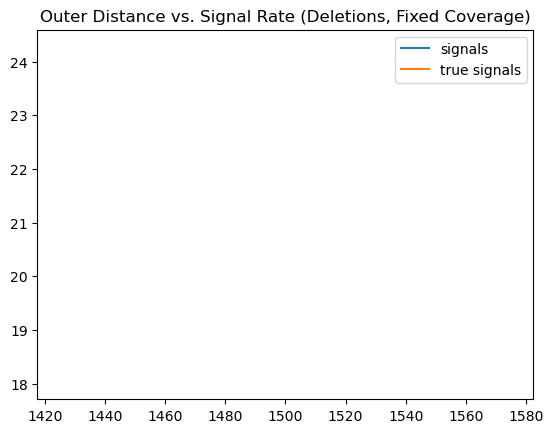

In [31]:
signals = [data2[od]["signal_rate"] for od in outer_dist]
true_signals = [data2[od]["true_rate"] for od in outer_dist]

plt.plot(outer_dist, signals, label = "signals")
plt.plot(outer_dist, true_signals, label = "true signals") 
plt.legend()
plt.title(f"Outer Distance vs. Signal Rate (Deletions, Fixed Coverage)")

In [38]:
data2[1500]["signals"]

array([  9,  14,   1,  17,   0, 117,   0,  24,   0,   0,   6,   4,   0,
         0,   5,   1,   0,   0,   0,   6,   4,   0,   5, 298,   0,   4,
         3,   0,   2,   0,   0,  30,   4,   2,   0,   1,   1,   1,   0,
         1,   0,   0,   4, 639,   5,   0,   0,   0,   3,   3])

{'whiskers': [<matplotlib.lines.Line2D at 0x176a3cc50>,
 'caps': [<matplotlib.lines.Line2D at 0x311cf19d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x30adb5350>],
 'medians': [<matplotlib.lines.Line2D at 0x3081b8e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x308124250>],
 'means': []}

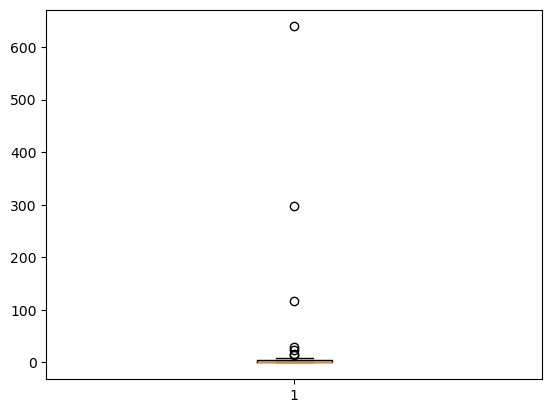

In [36]:
plt.boxplot(data2[1500]["signals"])

In [26]:
start_dists = [[data2[od]["mut"][i]["start_idx"] for i in range(10)] for od in outer_dist]

ValueError: x and y must be the same size

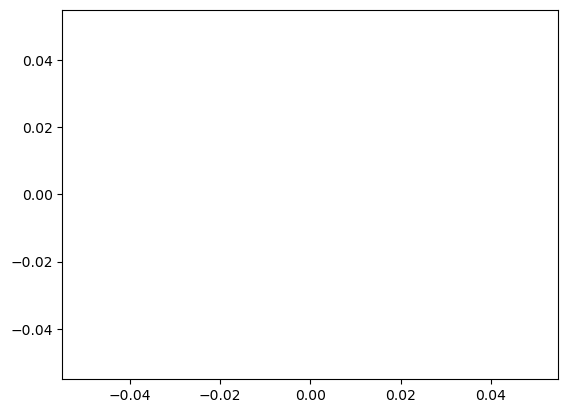

In [32]:
plt.scatter([], [], color = "blue", label = "True Signals") 
plt.scatter([], [], color = "red", label = "Signals")
for i in range(len(outer_dist)):
    plt.scatter(start_dists[i], data2[outer_dist[i]]["true_signals"], color = "blue", s = 5)
    plt.scatter(start_dists[i], data2[outer_dist[i]]["signals"], color = "red", s = 5)
plt.title("Signal Rates Along the Genome")
plt.legend()
plt.show()

In [ ]:
# experimental loop 
# had 250 in there originally - too small to control flip. 
outer_dist = [1500]
coverage = 10

# greedy checking
max_mut_size = 100_000
min_mut_size = 50_000

data2 = dict() 

# ------------------------------

for od in outer_dist:
    od_data = dict()
    od_data["true_signals"] = []
    od_data["signals"] = []
    od_data["results"] = []
    od_data["mut"] = []
    # GENERATION
    for i in range(50):
        full_fasta_loc, slice_fasta_loc, tree, mutation_records, cumulative_genomes = pick_a_nice_mutation([min_mut_size, max_mut_size], [3])
        print(f"od = {od}, i = {i}")

        mut = mutation_records["cell1"][0][0] 

        numreads = coverage * (right - left) // (2 * read_dict["readlen"]) 

        read_dict["numreads"] = numreads
        read_dict["outerdist"] = od
        read_prefix = f"{od}.{i}"

        results, suspects = readstep(read_dict, _readdir, refname, 
                                    fasta_name, 0, read_prefix, slice_fasta_loc, 
                                    verbose = False, log = "")

        arr = np.array(results, dtype=object)

        if len(arr) != 0:
            l_coords = arr[:, 1].astype(int)
            r_coords = arr[:, 2].astype(int)
            mapqs = arr[:, 3].astype(int)

            threshold = od * 5 + 2 * read_dict['readlen']
            island_mask = (l_coords > r_coords) | ((r_coords - l_coords) > threshold)
            highq_mask = mapqs == 60
            non_island_mask = ~island_mask
            background_mask = highq_mask & non_island_mask

            region_start = mut["prev_start_idx"]
            region_end = mut["prev_end_idx"]

            true_ins_mask = (l_coords > r_coords) & (r_coords > region_start) & (l_coords < region_end)
            true_del_mask = (l_coords < r_coords) & (l_coords < region_start) & (r_coords > region_end)
            true_island_mask = true_ins_mask | true_del_mask 

            od_data["true_signals"].append(true_island_mask.sum())
            od_data["signals"].append(island_mask.sum()) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        else:
            od_data["true_signals"].append(0)
            od_data["signals"].append(0) 

            od_data["results"].append(results)
            od_data["mut"].append(mut) 
        
    od_data["true_signals"] = np.asarray(od_data['true_signals'])
    od_data["true_rate"] = od_data["true_signals"].mean() 
    od_data["signals"] = np.asarray(od_data["signals"])
    od_data["signal_rate"] = od_data["signals"].mean()
    data2[od] = od_data

In [ ]:
triples = [[(d["mut"][i]['region_length'], d["signals"][i], d["true_signals"][i]) for i in range(50)] for d in data2.values()]

for i in range(len(outer_dist)):
    od = outer_dist[i]
    arr = np.asarray(triples[i])

    plt.scatter(arr[:, 0], arr[:, 1] - arr[:, 2], color = "red")
plt.legend()